In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Chemin du fichier CSV contenant les données
path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Chargement des données dans un DataFrame pandas
data = pd.read_csv(path)

In [3]:
features = ['MonthlyCharges', 'tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaymentMethod']

In [4]:
X = data[features].copy()
y = data['Churn'].copy()
y.replace({'Yes': 1, 'No': 0, ' ': np.nan}, inplace=True)

/var/folders/m4/p71xrbqx639250tkt6rzcx940000gn/T/ipykernel_68933/4054294933.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({'Yes': 1, 'No': 0, ' ': np.nan}, inplace=True)


In [5]:
X.isna().sum()

MonthlyCharges      0
tenure              0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaymentMethod       0
dtype: int64

In [6]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split


preprocessor = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(), make_column_selector(dtype_include=object))
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

X_train = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)

In [10]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])

/opt/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy', 'f1_score', 'AUC']
)

In [12]:
print(y_train.isna().sum())
print(y_test.isna().sum())

0
0


In [13]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [14]:
print(y_train.unique())
print(y_train.dtypes)

[0 1]
int64


In [15]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
total = neg + pos

In [16]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


<Axes: >

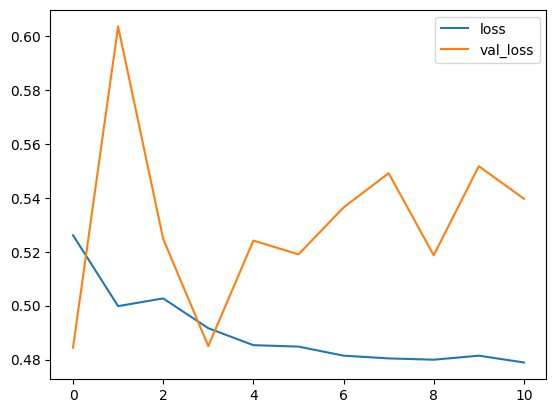

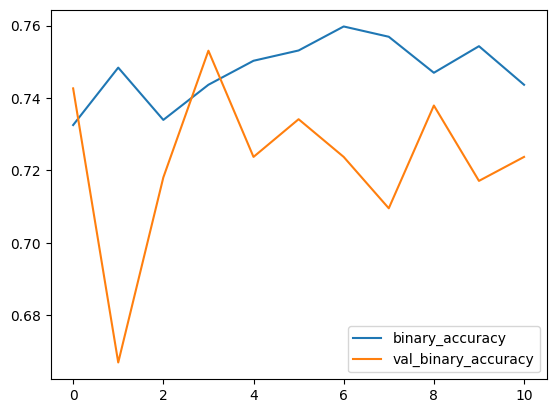

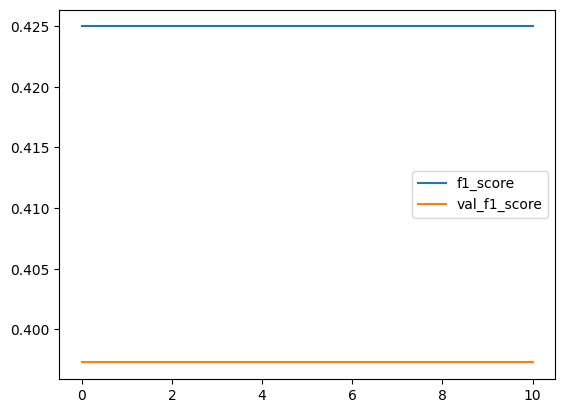

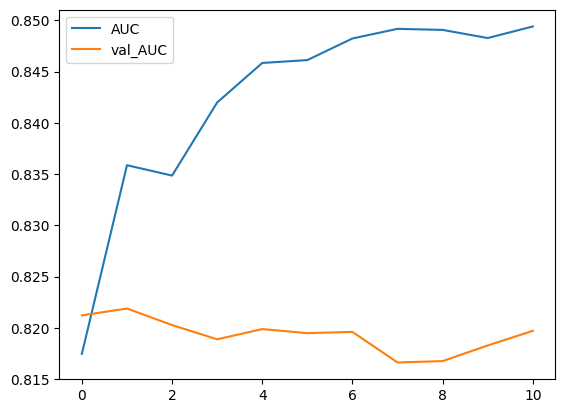

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=0
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
history_df.loc[:, ['f1_score', 'val_f1_score']].plot()
history_df.loc[:, ['AUC', 'val_AUC']].plot()

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialiser le modèle de régression logistique
logreg = LogisticRegression(max_iter=1000, class_weight=class_weight)

# Entraîner le modèle
logreg.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred = logreg.predict(X_test)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

# Afficher la matrice de confusion de manière plus lisible
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])
print(conf_matrix_df)

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1294
           1       0.51      0.80      0.62       467

    accuracy                           0.74      1761
   macro avg       0.71      0.76      0.71      1761
weighted avg       0.80      0.74      0.75      1761

            Predicted No  Predicted Yes
Actual No            930            364
Actual Yes            94            373


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialiser le modèle de forêt aléatoire
rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weight, random_state=0)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred_rf))

# Afficher la matrice de confusion de manière plus lisible
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_rf_df = pd.DataFrame(conf_matrix_rf, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])
print(conf_matrix_rf_df)

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1294
           1       0.54      0.45      0.49       467

    accuracy                           0.75      1761
   macro avg       0.68      0.66      0.67      1761
weighted avg       0.74      0.75      0.75      1761

            Predicted No  Predicted Yes
Actual No           1117            177
Actual Yes           256            211
